In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    RocCurveDisplay,
    precision_recall_curve,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score
)
import shap
import os

In [ ]:
class MLP_Enhanced(nn.Module):
    def __init__(self, input_dim):
        super(MLP_Enhanced, self).__init__()
        # Arquitectura mejorada para SMOTE y SMOTEENN (256-128-64)
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(1)

In [8]:
# Cargar datos de test
X_test = np.load("./trains/X_test_scaled.npy")
y_test = np.load("./trains/y_test.npy")
input_dim = X_test.shape[1]

# Configurar modelos con las arquitecturas correctas
models_config = {
    'normal': {
        'model_path': './models/mlp_normal.pth',
        'label': 'Normal',
        'model_class': MLP_Enhanced
    },
    'smote': {
        'model_path': './models/mlp_smote.pth',
        'label': 'SMOTE',
        'model_class': MLP_Enhanced
    },
    'smoteenn': {
        'model_path': './models/mlp_smoteenn.pth',
        'label': 'SMOTEENN',
        'model_class': MLP_Enhanced
    }
}

print(f"Test dataset: {X_test.shape}, Fraud ratio: {y_test.mean():.4f}")

Test dataset: (241672, 48), Fraud ratio: 0.0110


In [9]:
def get_best_threshold(y_true, y_scores):
    """Encuentra el mejor threshold basado en F1-Score"""
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
    f1s = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
    best_idx = np.argmax(f1s)
    return thresholds[best_idx] if best_idx < len(thresholds) else 0.5

def evaluate_model_with_threshold(y_true, y_pred_probs, threshold, model_name):
    """Evalúa modelo con threshold específico"""
    y_pred_labels = (y_pred_probs >= threshold).astype(int)
    
    print(f"\n=== {model_name} (threshold={threshold:.4f}) ===")
    print(classification_report(y_true, y_pred_labels, digits=4))
    print("AUC:", roc_auc_score(y_true, y_pred_probs))
    print("F1:", f1_score(y_true, y_pred_labels))
    print("Precision:", precision_score(y_true, y_pred_labels))
    print("Recall:", recall_score(y_true, y_pred_labels))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred_labels))
    
    return y_pred_labels

In [10]:
# Cargar y evaluar los 3 modelos
results = {}
predictions_data = {}

print("=" * 80)
print("EVALUANDO MODELOS MLP CON THRESHOLD ÓPTIMO")
print("=" * 80)

for name, config in models_config.items():
    print(f"\n--- Cargando modelo {name.upper()} ---")
    
    # Cargar modelo con la arquitectura correcta
    model = config['model_class'](input_dim)
    model.load_state_dict(torch.load(config['model_path'], map_location='cpu'))
    model.eval()
    
    # Predicciones con torch.no_grad y best_threshold
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        y_pred_logits = model(X_test_tensor)
        y_pred_probs = torch.sigmoid(y_pred_logits).numpy()
    
    # Encontrar mejor threshold
    best_threshold = get_best_threshold(y_test, y_pred_probs)
    
    # Evaluar con mejor threshold
    y_pred_labels = evaluate_model_with_threshold(
        y_test, y_pred_probs, best_threshold, f"MLP - {config['label']}"
    )
    
    # Crear DataFrame de resultados
    results_df = pd.DataFrame({
        "true_label": y_test,
        "pred_label": y_pred_labels,
        "pred_prob": y_pred_probs
    })
    
    # Guardar resultados
    results[name] = {
        'model': model,
        'y_pred_probs': y_pred_probs,
        'y_pred_labels': y_pred_labels,
        'best_threshold': best_threshold,
        'results_df': results_df
    }
    
    # Top fraudes
    top_fraudes = results_df.sort_values("pred_prob", ascending=False).head(10)
    print(f"\nTop 10 fraudes detectados:")
    print(top_fraudes)

EVALUANDO MODELOS MLP CON THRESHOLD ÓPTIMO

--- Cargando modelo NORMAL ---



=== MLP - Normal (threshold=0.3075) ===
              precision    recall  f1-score   support

           0     0.9917    0.9867    0.9892    239020
           1     0.1767    0.2568    0.2093      2652

    accuracy                         0.9787    241672
   macro avg     0.5842    0.6218    0.5993    241672
weighted avg     0.9828    0.9787    0.9807    241672

AUC: 0.8708962150058945
F1: 0.20934521979711035
Precision: 0.17669953295277632
Recall: 0.25678733031674206
Confusion Matrix:
 [[235847   3173]
 [  1971    681]]

Top 10 fraudes detectados:
        true_label  pred_label  pred_prob
157107           1           1   0.552939
66854            1           1   0.520266
15394            1           1   0.514321
239689           1           1   0.509406
90085            0           1   0.504086
231753           1           1   0.500946
140347           1           1   0.499923
216068           1           1   0.496468
100291           1           1   0.493816
16002            1     

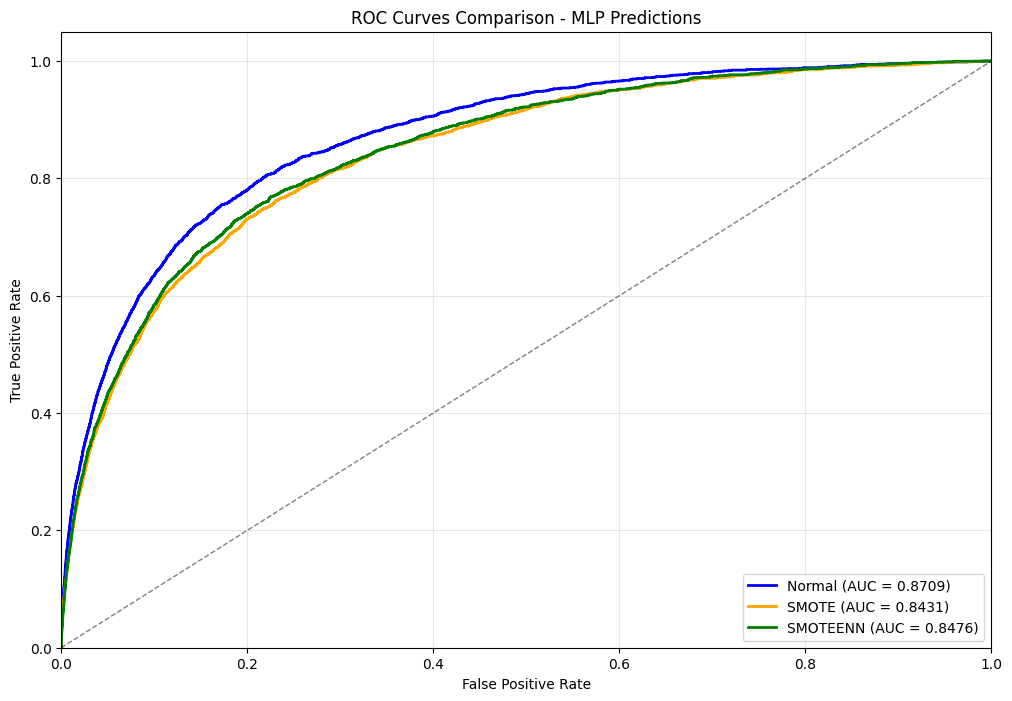

In [11]:
# Crear directorio para plots
os.makedirs("./plots/predictions", exist_ok=True)

# 1. Curvas ROC comparativas
plt.figure(figsize=(12, 8))

colors = ['blue', 'orange', 'green']
for i, (name, data) in enumerate(results.items()):
    fpr, tpr, _ = roc_curve(y_test, data['y_pred_probs'])
    auc_score = roc_auc_score(y_test, data['y_pred_probs'])
    plt.plot(fpr, tpr, color=colors[i], linewidth=2, 
             label=f'{models_config[name]["label"]} (AUC = {auc_score:.4f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison - MLP Predictions')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig('./plots/predictions/roc_curves_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

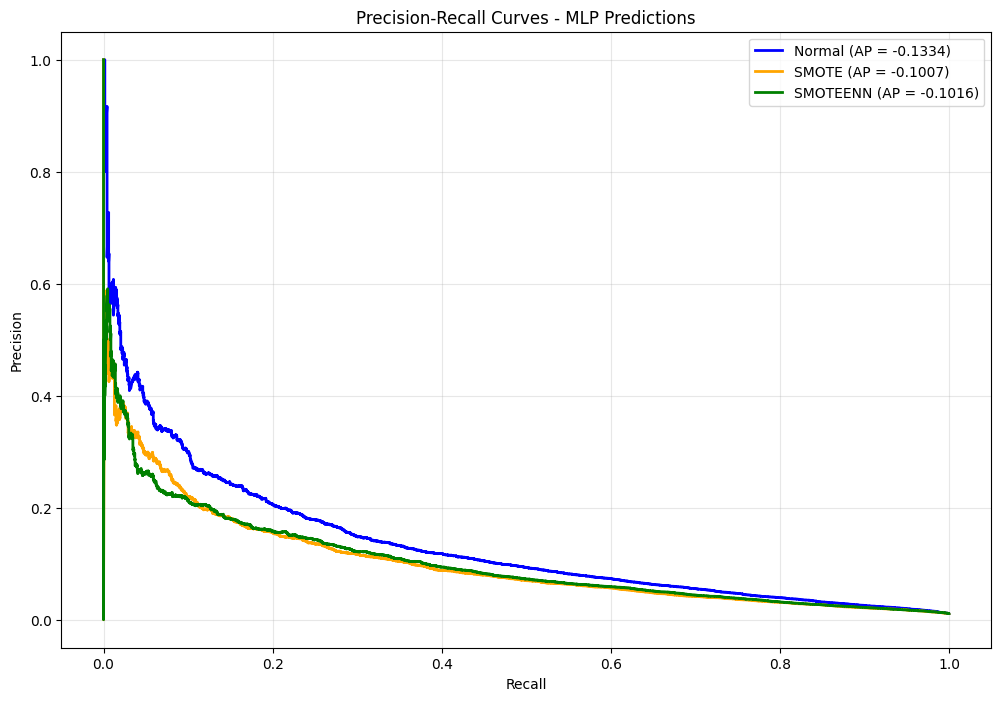

In [12]:
# 2. Precision-Recall Curves comparativas
plt.figure(figsize=(12, 8))

for i, (name, data) in enumerate(results.items()):
    precision, recall, _ = precision_recall_curve(y_test, data['y_pred_probs'])
    ap_score = np.trapz(precision, recall)
    plt.plot(recall, precision, color=colors[i], linewidth=2,
             label=f'{models_config[name]["label"]} (AP = {ap_score:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves - MLP Predictions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('./plots/predictions/precision_recall_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

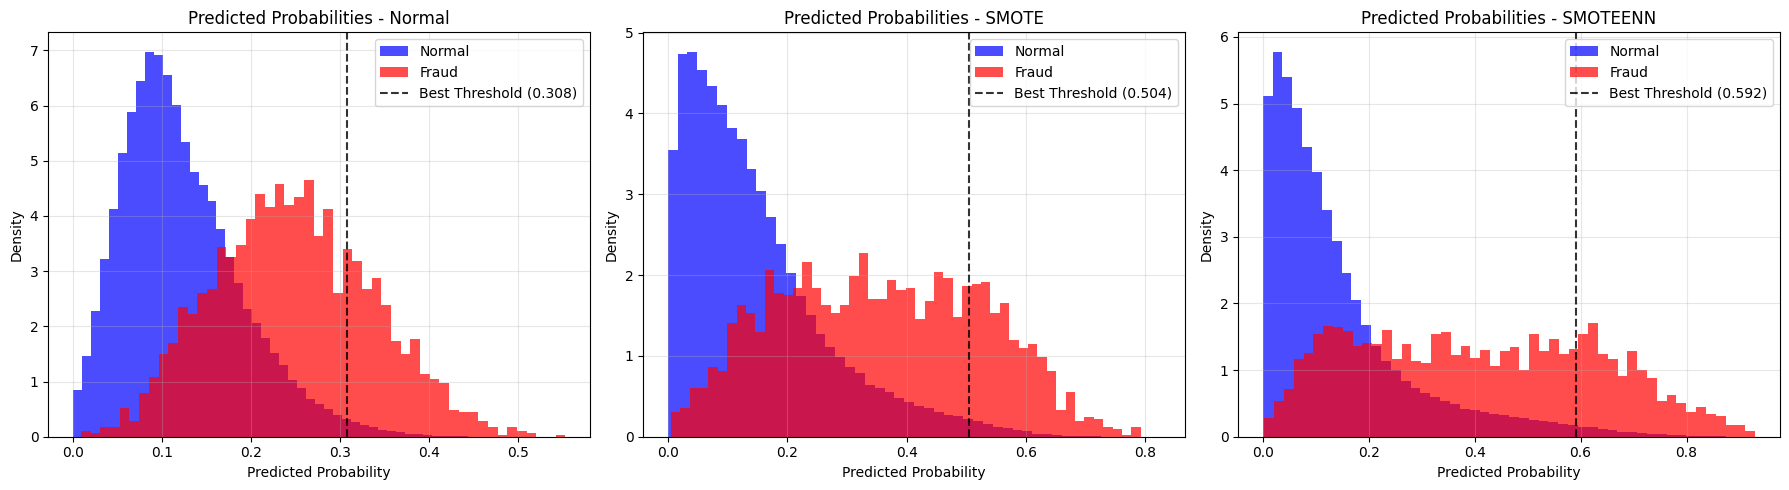

In [13]:
# 3. Distribuciones de probabilidades con best_threshold
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (name, data) in enumerate(results.items()):
    y_pred_probs = data['y_pred_probs']
    threshold = data['best_threshold']
    
    # Separar por clase real
    fraud_probs = y_pred_probs[y_test == 1]
    normal_probs = y_pred_probs[y_test == 0]
    
    axes[i].hist(normal_probs, bins=50, alpha=0.7, label='Normal', color='blue', density=True)
    axes[i].hist(fraud_probs, bins=50, alpha=0.7, label='Fraud', color='red', density=True)
    axes[i].axvline(x=threshold, color='black', linestyle='--', alpha=0.8, 
                    label=f'Best Threshold ({threshold:.3f})')
    axes[i].set_title(f'Predicted Probabilities - {models_config[name]["label"]}')
    axes[i].set_xlabel('Predicted Probability')
    axes[i].set_ylabel('Density')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./plots/predictions/probability_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

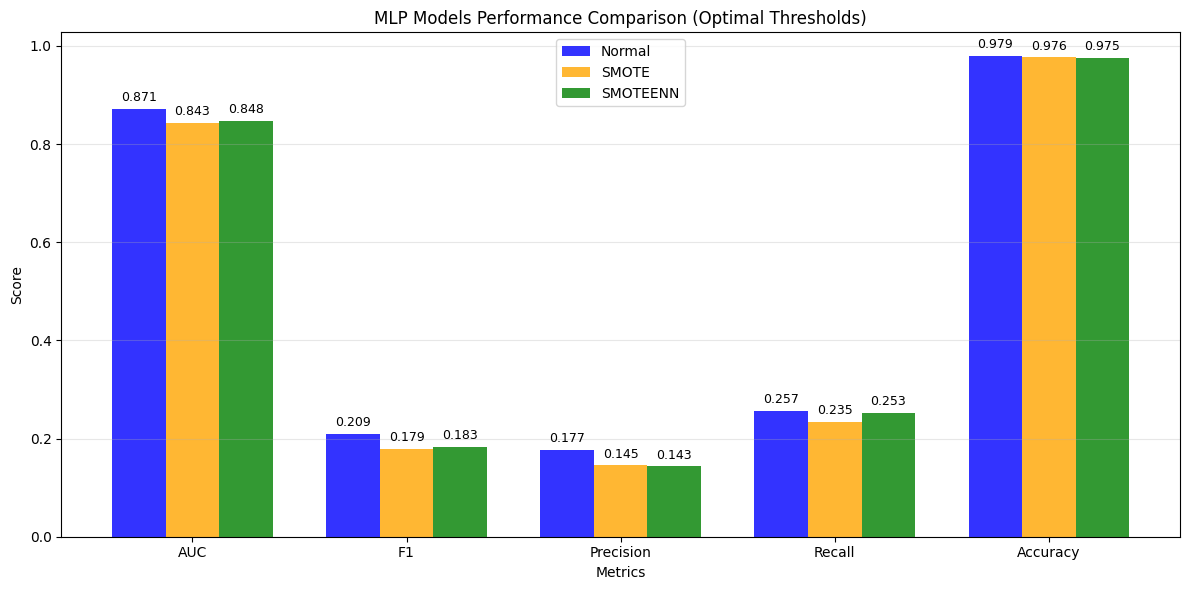

In [14]:
# 4. Métricas comparativas
metrics_data = {}
for name, data in results.items():
    y_pred_probs = data['y_pred_probs']
    y_pred_labels = data['y_pred_labels']
    
    metrics_data[name] = {
        'AUC': roc_auc_score(y_test, y_pred_probs),
        'F1': f1_score(y_test, y_pred_labels),
        'Precision': precision_score(y_test, y_pred_labels),
        'Recall': recall_score(y_test, y_pred_labels),
        'Accuracy': accuracy_score(y_test, y_pred_labels),
        'Threshold': data['best_threshold']
    }

# Gráfico de métricas (sin threshold)
metrics_to_plot = ['AUC', 'F1', 'Precision', 'Recall', 'Accuracy']
x_pos = np.arange(len(metrics_to_plot))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))

for i, (name, data) in enumerate(metrics_data.items()):
    values = [data[metric] for metric in metrics_to_plot]
    ax.bar(x_pos + i * width, values, width, 
           label=models_config[name]['label'], color=colors[i], alpha=0.8)

ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('MLP Models Performance Comparison (Optimal Thresholds)')
ax.set_xticks(x_pos + width)
ax.set_xticklabels(metrics_to_plot)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Añadir valores en las barras
for i, (name, data) in enumerate(metrics_data.items()):
    values = [data[metric] for metric in metrics_to_plot]
    for j, v in enumerate(values):
        ax.text(j + i * width, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('./plots/predictions/metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

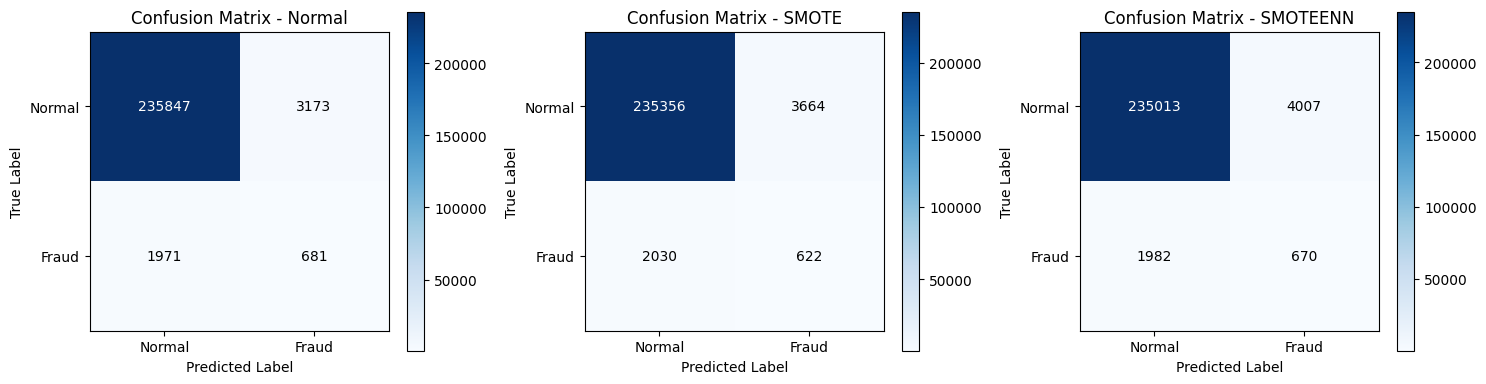

In [15]:
# 5. Matriz de confusión comparativa
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, (name, data) in enumerate(results.items()):
    cm = confusion_matrix(y_test, data['y_pred_labels'])
    
    im = axes[i].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    axes[i].figure.colorbar(im, ax=axes[i])
    
    # Añadir texto a las celdas
    for row in range(cm.shape[0]):
        for col in range(cm.shape[1]):
            axes[i].text(col, row, format(cm[row, col], 'd'),
                        ha="center", va="center", color="white" if cm[row, col] > cm.max() / 2 else "black")
    
    axes[i].set_ylabel('True Label')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_title(f'Confusion Matrix - {models_config[name]["label"]}')
    axes[i].set_xticks([0, 1])
    axes[i].set_yticks([0, 1])
    axes[i].set_xticklabels(['Normal', 'Fraud'])
    axes[i].set_yticklabels(['Normal', 'Fraud'])

plt.tight_layout()
plt.savefig('./plots/predictions/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

In [16]:
# 6. Análisis SHAP para el mejor modelo (mayor AUC)
best_model_name = max(metrics_data.keys(), key=lambda x: metrics_data[x]['AUC'])
best_model_data = results[best_model_name]
best_model = best_model_data['model']

print(f"\n--- Análisis SHAP para el mejor modelo: {models_config[best_model_name]['label']} ---")

# Preparar datos para SHAP
def model_predict(x):
    with torch.no_grad():
        return torch.sigmoid(best_model(torch.tensor(x, dtype=torch.float32))).detach().numpy()

explainer = shap.KernelExplainer(
    model=model_predict,
    data=X_test[:100]
)

print("Calculando valores SHAP...")
shap_values = explainer.shap_values(X_test[:100], nsamples=100)

# Preparar nombres de features
df = pd.read_csv("./data/preprocessed_data.csv")
df_test = df[df["month"] >= 6].copy()
X_test_named = df_test.drop(columns=["fraud_bool", "month", "x1", "x2"], errors="ignore")
X_test_named = pd.get_dummies(X_test_named, drop_first=True)
X_test_named = X_test_named.iloc[:, :X_test.shape[1]]
X_shap = pd.DataFrame(X_test[:100], columns=X_test_named.columns[:X_test.shape[1]])


--- Análisis SHAP para el mejor modelo: Normal ---
Calculando valores SHAP...


100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


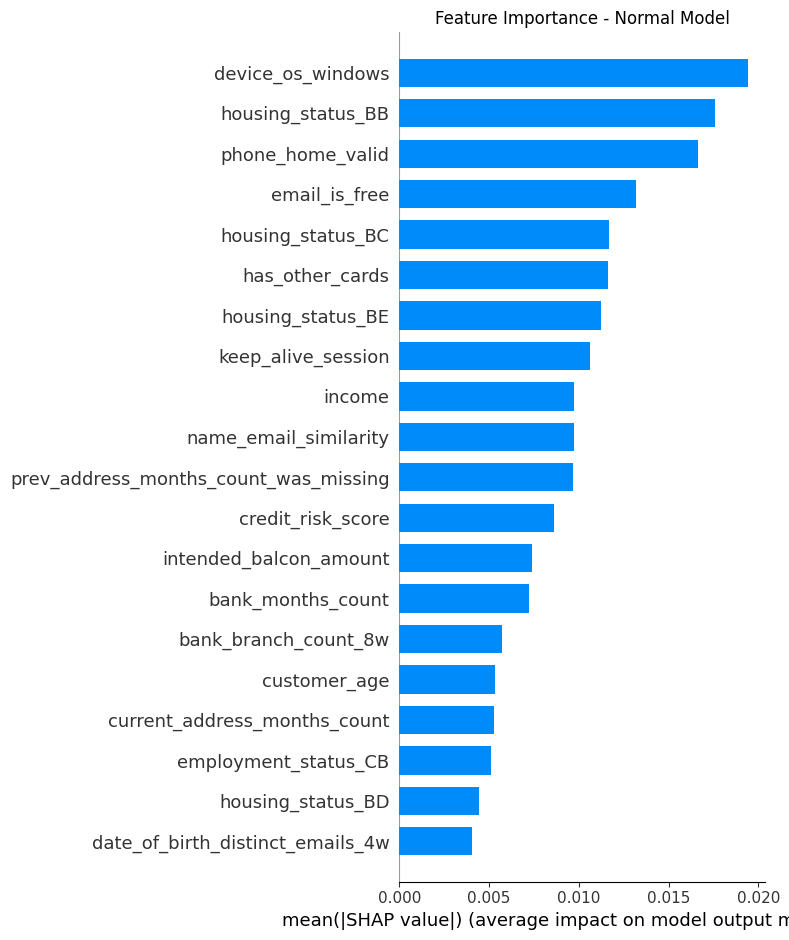

In [17]:
# 7. SHAP Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_shap, plot_type="bar", show=False)
plt.title(f'Feature Importance - {models_config[best_model_name]["label"]} Model')
plt.tight_layout()
plt.savefig(f'./plots/predictions/shap_summary_{best_model_name}.png', dpi=300, bbox_inches='tight')
plt.show()

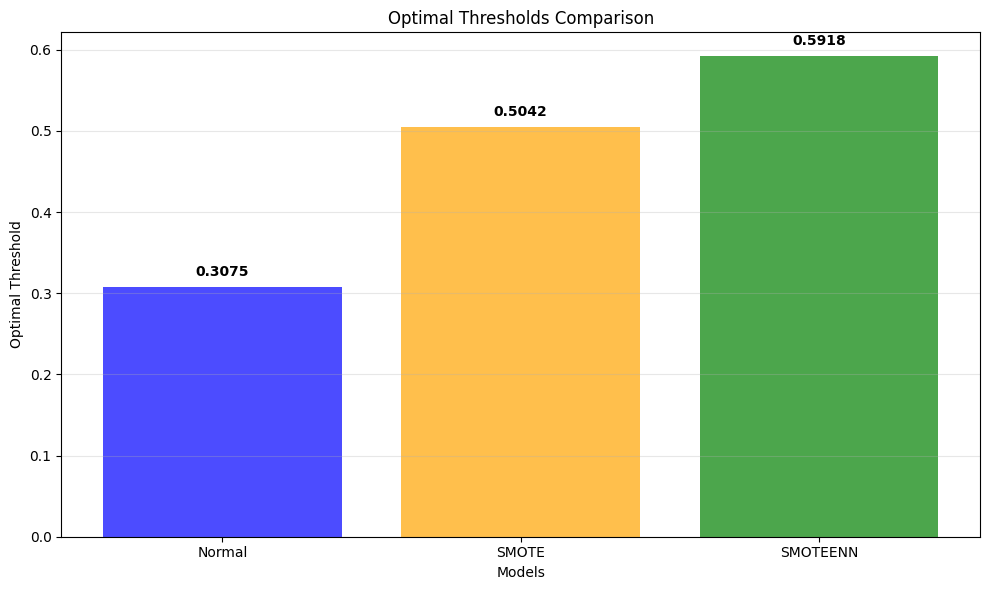

In [18]:
# 8. Comparación de thresholds
plt.figure(figsize=(10, 6))

threshold_data = [(name, data['best_threshold']) for name, data in results.items()]
threshold_data.sort(key=lambda x: x[1])

names, thresholds = zip(*threshold_data)
colors_thresh = [colors[list(results.keys()).index(name)] for name in names]

bars = plt.bar(range(len(names)), thresholds, color=colors_thresh, alpha=0.7)
plt.xlabel('Models')
plt.ylabel('Optimal Threshold')
plt.title('Optimal Thresholds Comparison')
plt.xticks(range(len(names)), [models_config[name]['label'] for name in names])
plt.grid(True, alpha=0.3, axis='y')

# Añadir valores en las barras
for bar, threshold in zip(bars, thresholds):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{threshold:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('./plots/predictions/thresholds_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [19]:
# 9. Resumen final
print("\n" + "="*80)
print("RESUMEN FINAL - PREDICCIONES CON THRESHOLD ÓPTIMO")
print("="*80)

print(f"{'Model':<12} {'AUC':<8} {'F1':<8} {'Precision':<10} {'Recall':<8} {'Accuracy':<9} {'Threshold':<10}")
print("-" * 75)

for name in ['normal', 'smote', 'smoteenn']:
    data = metrics_data[name]
    model_label = models_config[name]['label']
    print(f"{model_label:<12} {data['AUC']:<7.4f} {data['F1']:<7.4f} {data['Precision']:<9.4f} "
          f"{data['Recall']:<7.4f} {data['Accuracy']:<8.4f} {data['Threshold']:<9.4f}")

print(f"\nMejor modelo por AUC: {models_config[best_model_name]['label']} "
      f"(AUC = {metrics_data[best_model_name]['AUC']:.4f})")

print("\nGráficos guardados en ./plots/predictions/:")
print("  - roc_curves_comparison.png")
print("  - precision_recall_comparison.png")
print("  - probability_distributions.png")
print("  - metrics_comparison.png")
print("  - confusion_matrices.png")
print("  - thresholds_comparison.png")
print(f"  - shap_summary_{best_model_name}.png")


RESUMEN FINAL - PREDICCIONES CON THRESHOLD ÓPTIMO
Model        AUC      F1       Precision  Recall   Accuracy  Threshold 
---------------------------------------------------------------------------
Normal       0.8709  0.2093  0.1767    0.2568  0.9787   0.3075   
SMOTE        0.8431  0.1793  0.1451    0.2345  0.9764   0.5042   
SMOTEENN     0.8476  0.1828  0.1433    0.2526  0.9752   0.5918   

Mejor modelo por AUC: Normal (AUC = 0.8709)

Gráficos guardados en ./plots/predictions/:
  - roc_curves_comparison.png
  - precision_recall_comparison.png
  - probability_distributions.png
  - metrics_comparison.png
  - confusion_matrices.png
  - thresholds_comparison.png
  - shap_summary_normal.png



--- Análisis de errores para Normal ---
Falsos Positivos: 3173 (1.31%)
Falsos Negativos: 1971 (0.82%)
Verdaderos Positivos: 681
Verdaderos Negativos: 235847

Top 5 Falsos Positivos (prob más alta):
        pred_prob  true_label  pred_label
90085    0.504086           0           1
197285   0.488875           0           1
177935   0.488556           0           1
102925   0.488540           0           1
51754    0.488262           0           1

--- Análisis de errores para SMOTE ---
Falsos Positivos: 3664 (1.52%)
Falsos Negativos: 2030 (0.84%)
Verdaderos Positivos: 622
Verdaderos Negativos: 235356

Top 5 Falsos Positivos (prob más alta):
        pred_prob  true_label  pred_label
90085    0.825051           0           1
34124    0.800256           0           1
43483    0.792965           0           1
227459   0.779273           0           1
51905    0.773631           0           1

--- Análisis de errores para SMOTEENN ---
Falsos Positivos: 4007 (1.66%)
Falsos Negativos: 1982 (0

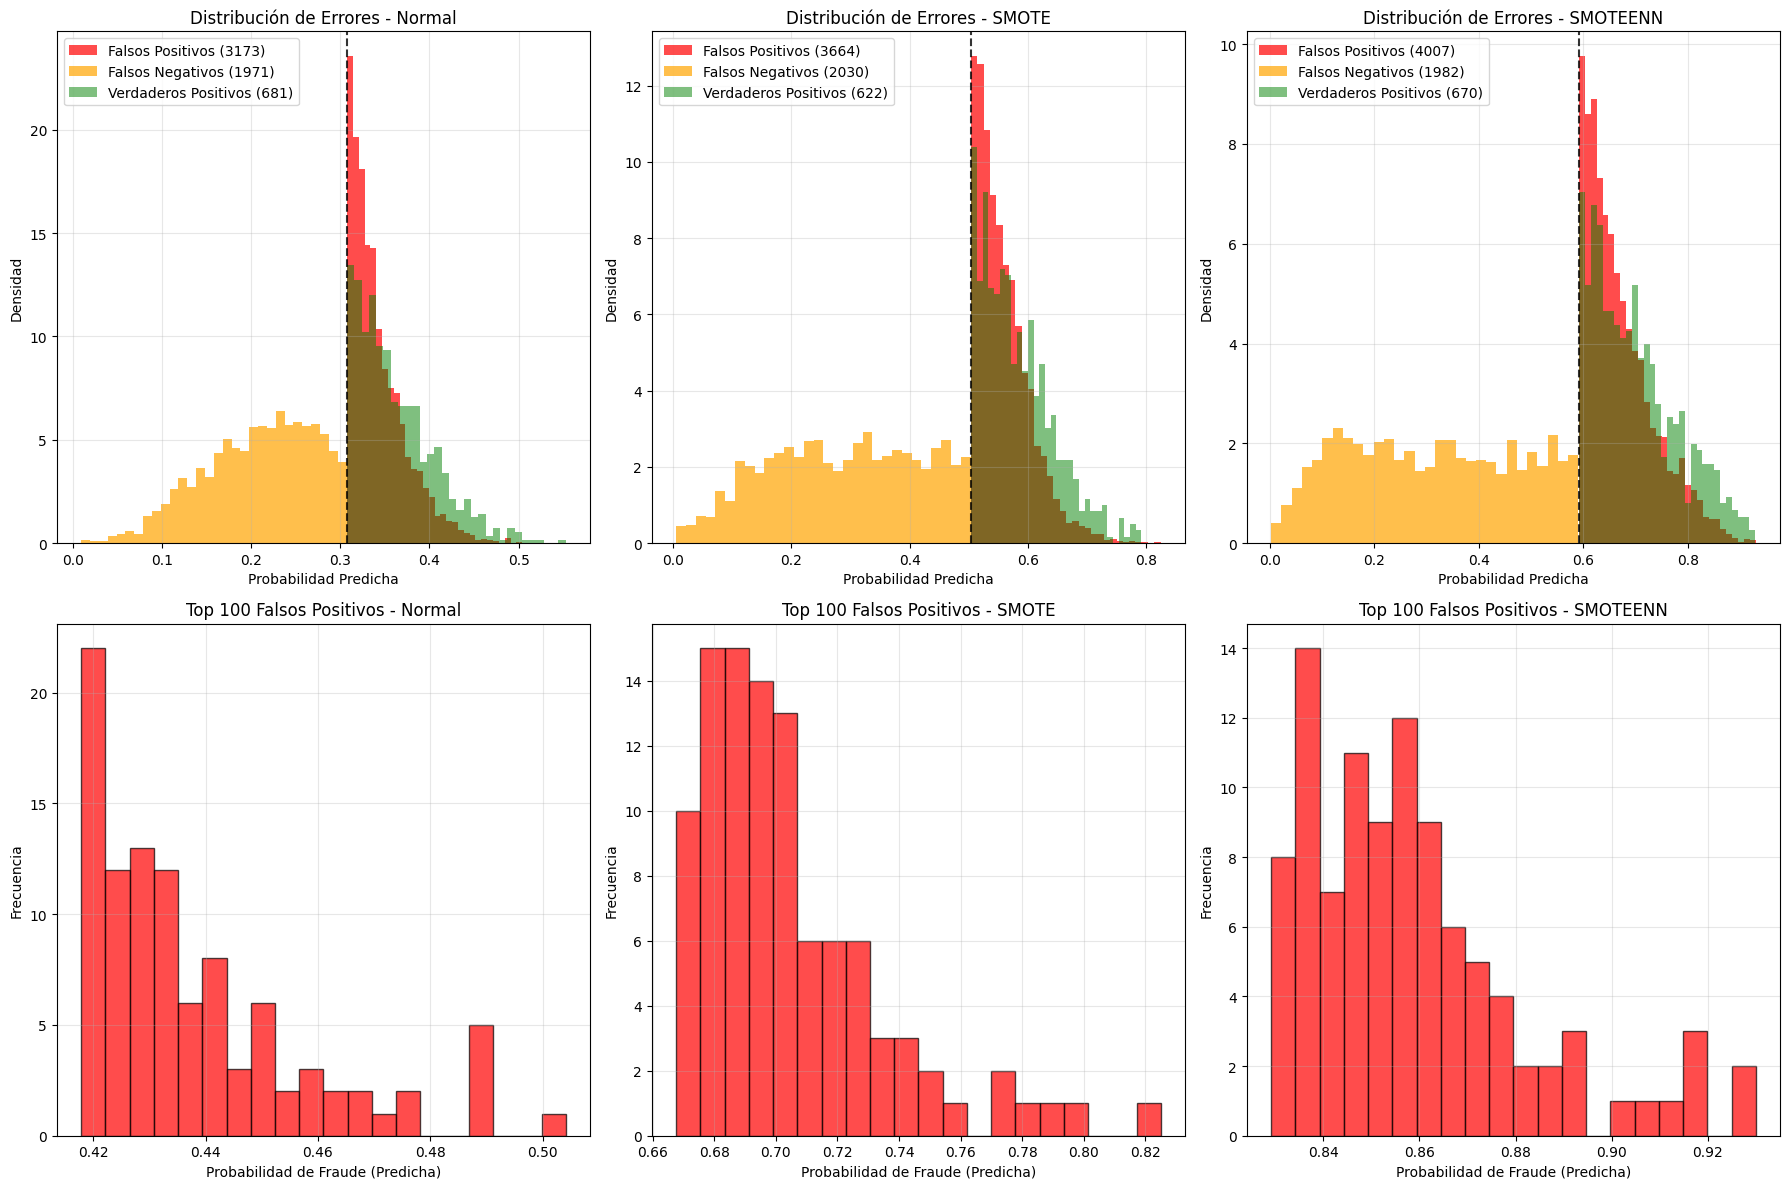

In [20]:
#! Cuidado
# 10. Análisis de Falsos Positivos y Falsos Negativos
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, (name, data) in enumerate(results.items()):
    results_df = data['results_df']
    
    # Identificar falsos positivos y falsos negativos
    false_positives = results_df[(results_df['true_label'] == 0) & (results_df['pred_label'] == 1)]
    false_negatives = results_df[(results_df['true_label'] == 1) & (results_df['pred_label'] == 0)]
    true_positives = results_df[(results_df['true_label'] == 1) & (results_df['pred_label'] == 1)]
    true_negatives = results_df[(results_df['true_label'] == 0) & (results_df['pred_label'] == 0)]
    
    print(f"\n--- Análisis de errores para {models_config[name]['label']} ---")
    print(f"Falsos Positivos: {len(false_positives)} ({len(false_positives)/len(results_df)*100:.2f}%)")
    print(f"Falsos Negativos: {len(false_negatives)} ({len(false_negatives)/len(results_df)*100:.2f}%)")
    print(f"Verdaderos Positivos: {len(true_positives)}")
    print(f"Verdaderos Negativos: {len(true_negatives)}")
    
    # Gráfico 1: Distribución de probabilidades por tipo de predicción
    axes[0, i].hist(false_positives['pred_prob'], bins=30, alpha=0.7, 
                    label=f'Falsos Positivos ({len(false_positives)})', color='red', density=True)
    axes[0, i].hist(false_negatives['pred_prob'], bins=30, alpha=0.7, 
                    label=f'Falsos Negativos ({len(false_negatives)})', color='orange', density=True)
    axes[0, i].hist(true_positives['pred_prob'], bins=30, alpha=0.5, 
                    label=f'Verdaderos Positivos ({len(true_positives)})', color='green', density=True)
    
    threshold = data['best_threshold']
    axes[0, i].axvline(x=threshold, color='black', linestyle='--', alpha=0.8)
    axes[0, i].set_title(f'Distribución de Errores - {models_config[name]["label"]}')
    axes[0, i].set_xlabel('Probabilidad Predicha')
    axes[0, i].set_ylabel('Densidad')
    axes[0, i].legend()
    axes[0, i].grid(True, alpha=0.3)
    
    # Gráfico 2: Top falsos positivos (mayor probabilidad de fraude pero son normales)
    top_fp = false_positives.nlargest(100, 'pred_prob')
    axes[1, i].hist(top_fp['pred_prob'], bins=20, alpha=0.7, color='red', edgecolor='black')
    axes[1, i].set_title(f'Top 100 Falsos Positivos - {models_config[name]["label"]}')
    axes[1, i].set_xlabel('Probabilidad de Fraude (Predicha)')
    axes[1, i].set_ylabel('Frecuencia')
    axes[1, i].grid(True, alpha=0.3)
    
    # Mostrar algunos ejemplos
    print(f"\nTop 5 Falsos Positivos (prob más alta):")
    print(false_positives.nlargest(5, 'pred_prob')[['pred_prob', 'true_label', 'pred_label']])

plt.tight_layout()
plt.savefig('./plots/predictions/false_positives_analysis.png', dpi=300, bbox_inches='tight')
plt.show()